# Introduction to Explainable Artificial Intelligence (XAI) using PyTorch

In this Jupyter Notebook, we're going to learn about making Artificial Intelligence (AI) easier to understand. We focus on a concept called Explainable AI (XAI), which helps clarify how AI systems make decisions. This is important because many advanced AI systems are like "black boxes"—it's difficult to see inside them to understand how they work. We cover why it's important for AI to be clear and easy to understand, especially in important areas such as healthcare, finance, and automated systems. We look at different methods, such as analysing what features are important, showing decisions with trees, and simplifying models. We also include real-life examples and studies to help explain these ideas better. The goal is to make AI not just easier to understand but also more reliable, ensuring it matches our human values and ethical standards.

## Questions
1) What is Explainable Artificial Intelligence (XAI), and why is it important?
2) How does XAI address the "black box" problem associated with traditional AI systems?
3) Can you discuss any specific techniques or methodologies used in XAI to make AI decisions more understandable to humans?
4) How does XAI contribute to the ethical use of AI technologies?
5) In what ways can XAI improve trust and transparency between AI systems and their end-users?
6) Could the implementation of XAI impact the performance of AI systems? If so, how?
7) Discuss a real-world application where XAI has significantly improved decision-making processes or outcomes.
8) How do regulations and policies around the world influence the development and adoption of XAI?

## Objective

The main objective of this module is to understand Explainable AI and apply different methods to understand the decision making of AI models.

## Datasets
PathMNIST

## References
- "Interpretable Machine Learning" by Christoph Molnar

- "Explainable AI: Interpreting, Explaining and Visualizing Deep Learning" by Wojciech Samek, et al.


### Introduction to Explainable Artificial Intelligence (XAI)

Artificial Intelligence (AI) has become integral to various facets of human activity, enhancing capabilities and facilitating efficiencies hitherto unimaginable. However, the advent of sophisticated AI systems has given rise to a phenomenon known as the "black box" problem, where the decision-making processes of AI algorithms remain vague and incomprehensible to humans. This opacity requires the development and implementation of Explainable Artificial Intelligence (XAI), aimed at making the workings of AI systems transparent, understandable, and trustworthy. XAI is essential for bridging the advanced functionalities of AI with the fundamental human need for comprehension, ensuring the ethical and effective use of AI technologies.

### The Importance of Explainable AI (XAI)

#### Tackling the "Black Box" Problem

Modern AI systems can be complex and often act like "black boxes" where even the creators can't easily see how decisions are made. This lack of clear understanding is especially concerning in important areas like healthcare, finance, and legal matters, where knowing the reasons behind decisions is essential.

#### Building Trust with Transparency

XAI aims to make the decision-making processes of AI clear and open. This transparency helps build trust, ensuring that AI can be checked for ethical issues, compliance with laws, and consistency with human values. Trust is key for people to accept and ethically use AI in different sectors.

### Explaining How XAI Works

XAI uses several methods to make AI systems easier to understand:

- **Feature Importance Analysis** identifies which factors have a big impact on AI decisions, giving us a clearer picture of what the AI considers important.
- **Decision Tree Visualization** shows the AI's decision-making process in simple, sequential steps, making it easier to follow how a decision is reached.
- **Model Simplification** tries to make complex AI models simpler to understand, finding a good balance between keeping the model effective and making it understandable.

### Tutorial on Specific XAI Techniques

In this tutorial, we explain two specific methods of XAI:

1. **Occlusion:** This technique involves systematically hiding different parts of the data input to the AI to see how each part affects the AI's decisions. This helps us understand which parts of the data are most important for the AI's conclusions.

2. **LIME (Local Interpretable Model-agnostic Explanations):** LIME helps to make AI decisions clearer by creating simple models that approximate the predictions of the complex AI model. This method explains the prediction of an AI model by approximating it locally with an interpretable model.


### XAI in Action: Examples and Case Studies

- **Healthcare**: XAI enables a deeper understanding of AI-driven diagnostics, enhancing the collaboration between AI systems and medical professionals.
- **Finance**: XAI ensures that AI-made financial decisions are transparent and accountable, building customer trust and facilitating regulatory compliance.
- **Automotive Industry**: In autonomous driving, XAI clarifies the vehicle's decision-making processes, crucial for safety and regulatory approval.

In this notebook, we will focus on applying XAI on medical data.

## Import Libraries

In [2]:
# Import the modules required:
import torch # this is the PyTorch module
import torch.nn as nn # this is the neural network module
import torch.nn.functional as F # this is the functional module
import torch.optim as optim # this is the optimizer module
import torchvision # this is the vision module

import warnings
warnings.filterwarnings("ignore") # this is to ignore warnings

# Import the MNIST dataset
from torchvision import datasets, transforms

# Import the matplotlib module
import matplotlib.pyplot as plt

# Import the numpy module
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# import medmnist, the medical image dataset
import medmnist
from medmnist import INFO, Evaluator

# fix the numpy and torch seeds for reproducibility:
SEED = 999
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


## CNNs on medical images with XAI integration

In this activity, we will utilise the model we trained in the previous exercise to explore and interpret the predictions using methods referred to as explainability techniques. We need to import our dataset, the model architecture, and the previously trained weights from the last exercise.

In [3]:
# --------------
# THE DATA
# --------------
import torch.utils.data as data

data_flag = 'pathmnist'
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, root='./data/')
test_dataset = DataClass(split='test', transform=data_transform, download=download, root='./data/')

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz


In [4]:
# ----------------------
# THE MODEL ARCHITECTURE
# ----------------------

# Here we are redefining the CNN class we used to train the model in the last lesson.

class CNN_Pathology(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_Pathology, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            # a dropout layer is added here to avoid overfitting
            nn.Dropout(p=0.6),
            nn.Linear(128, 128),
            nn.ReLU(),
            # a dropout layer is added here to avoid overfitting
            nn.Dropout(p=0.6),
            nn.Linear(128, num_classes))

    def forward(self, x):
        out = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5)(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
# --------------------------
# THE TRAINED MODEL WEIGHTS
# --------------------------

# Define the device, so we can use the GPU if available:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# then define the model (architecture above) and move it to the device:
model = CNN_Pathology(in_channels=n_channels, num_classes=n_classes)
# load the trained model that we saved in the last lesson, instead of having to train it again:
model.load_state_dict(torch.load('./data/best_model.pth'))
model = model.to(device)

In [6]:
# load all the test set images and labels into memory:
test_images = []
test_labels = []
for images, labels in test_loader:
    test_images.append(images)
    test_labels.append(labels)
test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

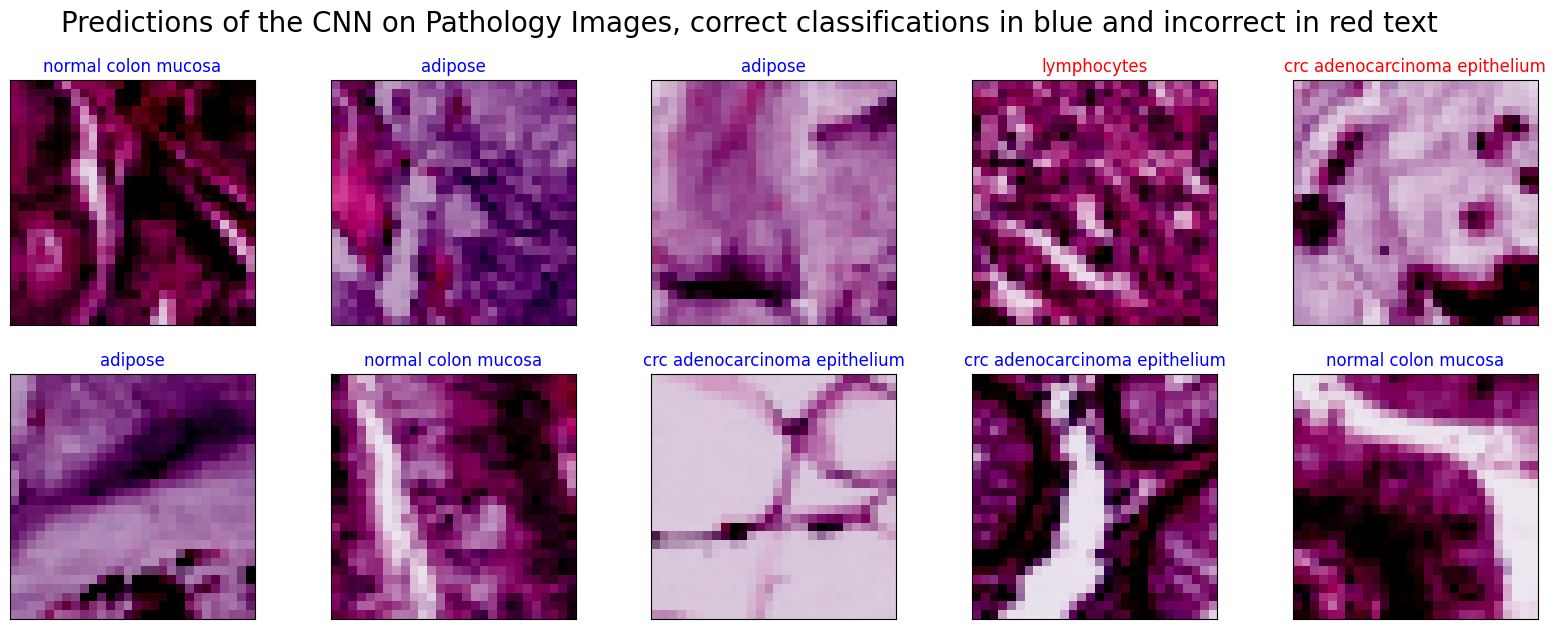

In [9]:
# Let us now visualize the predictions of the model on the test set, again:

# obtain one batch of test images
dataiter = iter(test_loader)
#images, labels = dataiter.next()
images, labels = next(dataiter)
images = images.numpy()

# move model inputs to cuda, if GPU available
images = images
labels = labels
images = torch.from_numpy(images)
images = images.to(device)
labels = labels.to(device)

# get sample outputs
# set model to eval mode
model.eval()
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 7))

real_labels = {
            0: "adipose",
            1: "background",
            2: "debris",
            3: "lymphocytes",
            4: "mucus",
            5: "smooth muscle",
            6: "normal colon mucosa",
            7: "cancer-associated stroma",
            8: "crc adenocarcinoma epithelium"
        }
for idx in np.arange(10):
    # get the real labels of the pathology images
    # and use these real labels to annotate the images
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.clip(np.transpose(images[idx], (1, 2, 0)), 0, 1))
    ax.set_title(f"{real_labels[int(preds[preds[idx]].cpu().numpy())]}", color=("blue" if preds[idx]==labels[idx] else "red"))

# add super title:
fig.suptitle('Predictions of the CNN on Pathology Images, correct classifications in blue and incorrect in red text', fontsize=20)
plt.show()

## Deployment
A trained model can be deployed to classify new images that it has not encountered during training. This capability is particularly beneficial in environments requiring automatic classification of samples. For example, in a clinical setting, it could assist clinicians by analysing patient samples to aid in diagnosis. Although we will not deploy our model in this exercise, we will use it to analyse and interpret the model's predictions using explainable methods.

## Explainability
 - We want to see if the network has learnt any features that we can translate into medical knowledge. We will be using some common explainability methods to visualise the features that the network has learnt.
 - To do this, we will be using a Python package called Captum, which is a model interpretability library for PyTorch. It is an easy to use tool for understanding the decisions made by a neural network. It is also a great tool for debugging and improving models.
 
### Method 1: Occlusion
 - To start off, we can use an explainability method called Occlusion. This is a visualisation technique that can be used to understand the importance of different regions of an image in the model's prediction. 
 - It does this by occluding (hiding) different regions of the image and observing the effect on the model's prediction. If the model's prediction changes a lot when a region is occluded, then that region is important for the model's prediction. If the model's prediction does not change a lot when a region is occluded, then that region is not important for the model's prediction.

<div style="text-align: center;">
    <img src="./data/occlusion.png" alt="./data/occlusion.png" width="30%">
</div>

<small>Image from Lindworm, E. (2021, January). [InShort: Occlusion Analysis for Explaining DNNs](https://towardsdatascience.com/inshort-occlusion-analysis-for-explaining-dnns-d0ad3af9aeb6). 
Towards Data Science.</small>

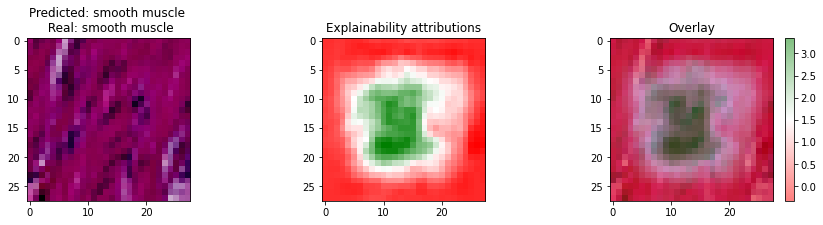

In [72]:
# let us only consider the samples that were classified correctly by the model:
correct_indices = []
for i in range(len(labels)):
    if preds[i] == labels[i]:
        correct_indices.append(i)

# shuffle the correct indices list:
np.random.shuffle(correct_indices)

# import captum and use it to infer the importance of each pixel in the image for the model’s prediction:
from captum.attr import Occlusion

# define the occlusion interpreter
occlusion = Occlusion(model)

# define the sliding window size for the occlusion interpreter
sliding_window_shapes = (3, 2, 2)

# # define the stride for the occlusion interpreter
strides = (3, 1, 1)

# define the number of classes for the occlusion interpreter
n_classes = len(np.unique(test_labels.cpu().numpy()))

# select a random index from correct_indices
IMAGE_INDEX = np.random.choice(correct_indices)

# now use the occlusion interpreter to infer the importance of each pixel in the image for the model’s prediction:
# get the first image in the test set
image = test_images[IMAGE_INDEX].unsqueeze(0)

# get the label of the first image in the test set
label = test_labels[IMAGE_INDEX]

# move the image and label to the device
image = image.to(device)
label = label.to(device)
# get the prediction of the model for the image
# set model to eval mode
model.eval()
output = model(image)

# convert output probabilities to predicted class
_, pred_class = torch.max(output, 1)

# now run the occlusion interpreter on the image
attributions_occ = occlusion.attribute(image,
                                        strides=strides,
                                        target=pred_class,
                                        sliding_window_shapes=sliding_window_shapes,
                                        )

# now visualize the attributions:
# define the real labels of the pathology images
real_labels = {
            0: "adipose",
            1: "background",
            2: "debris",
            3: "lymphocytes",
            4: "mucus",
            5: "smooth muscle",
            6: "normal colon mucosa",
            7: "cancer-associated stroma",
            8: "crc adenocarcinoma epithelium"
        }


# pred class in text:
pred_class_text = real_labels[int(pred_class.cpu().numpy())]

# real label in text:
real_label_text = real_labels[int(label.cpu().numpy())]


# --------------------------
# PLOTTING
# --------------------------
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

# plot the image and the attributions in a side by side manner as a subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1))
ax[0].set_title(f"Predicted: {pred_class_text} \n Real: {real_label_text}")
ax[1].imshow(attributions_occ.detach().cpu().numpy()[0][0], cmap=cmap)
ax[1].set_title("Explainability attributions")
# make an overlay of the image and the attributions
ax[2].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1))
ax[2].imshow(attributions_occ.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.1)
ax[2].set_title("Overlay")

# put a colorbar on the side
fig.colorbar(ax[2].imshow(attributions_occ.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.5), ax=ax[2])



plt.show()


- To make the process less tedious, let us define a function that takes as input the index of the image we want to visualize, and returns the plot:


In [73]:
def plot_attribution_image(index, save_str=None):
    # import captum and use it to infer the importance of each pixel in the image for the model’s prediction:
    
    from captum.attr import Occlusion

    # define the occlusion interpreter
    occlusion = Occlusion(model)

    # # define the sliding window size for the occlusion interpreter
    sliding_window_shapes = (3, 2, 2)

    # # define the stride for the occlusion interpreter
    strides = (3, 1, 1)

    # define the number of classes for the occlusion interpreter
    n_classes = len(np.unique(test_labels.cpu().numpy()))

    # now use the occlusion interpreter to infer the importance of each pixel in the image for the model’s prediction:
    # get the first image in the test set
    image = test_images[index].unsqueeze(0)

    # move the image to GPU if CUDA is available
    image = image.to(device)

    # get the model’s prediction
    # set model to eval mode
    model.eval()
    pred = model(image)

    # get the model’s prediction class
    pred_class = pred.argmax(dim=1)

    # now run the occlusion interpreter on the image
    attributions_occ = occlusion.attribute(image,
                                            strides=strides,
                                            target=pred_class,
                                            sliding_window_shapes=sliding_window_shapes,
                                            baselines=0,
                                            perturbations_per_eval=100
                                            )

    # define the real labels of the pathology images
    real_labels = {
                0: "adipose",
                1: "background",
                2: "debris",
                3: "lymphocytes",
                4: "mucus",
                5: "smooth muscle",
                6: "normal colon mucosa",
                7: "cancer-associated stroma",
                8: "crc adenocarcinoma epithelium"
            }

    # --------------------------
    # PLOTTING
    # --------------------------
    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
    # plot the image and the attributions in a side by side manner as a subplot
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    ax[0].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1))
    ax[0].set_title(f"Predicted: {real_labels[int(pred_class.cpu().numpy())]} \n Real: {real_labels[int(test_labels[index].cpu().numpy())]}")
    ax[1].imshow(attributions_occ.detach().cpu().numpy()[0][0], cmap=cmap)
    ax[1].set_title("Explainability attributions")
    # make an overlay of the image and the attributions
    ax[2].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1))
    ax[2].imshow(attributions_occ.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.4)
    ax[2].set_title("Overlay")

    # put a colorbar on the side
    fig.colorbar(ax[2].imshow(attributions_occ.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.4), ax=ax[2])

    if save_str is not None:
        plt.savefig(save_str, dpi=300, bbox_inches='tight')

    return plt.show()


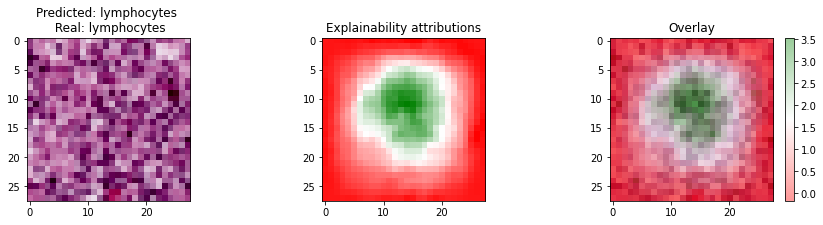

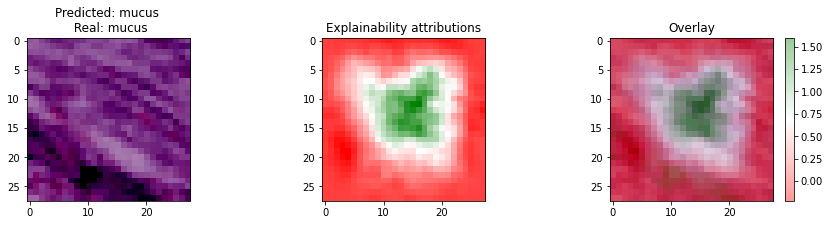

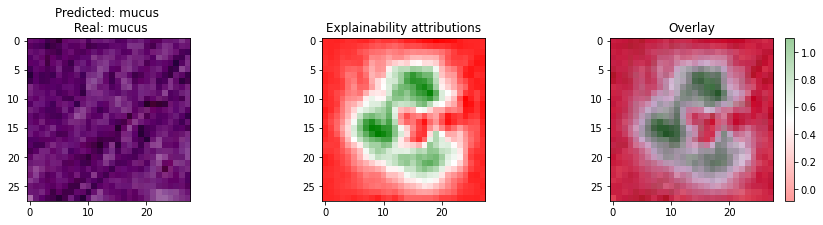

In [82]:
# Let us now visualize the attributions of the Occulusion interpreter on 3 randomly chosen correctly classified images:

number_of_images = 3
for i in range(number_of_images):
    # randomly choose 3 indices from the correct indices list:
    random_indices = np.random.choice(correct_indices, number_of_images)
    plot_attribution_image(random_indices[i])

## Interpretation
 - Heatmaps such as the above are often difficult to interpret, they highlight some important regions within the image that the network has used to make its prediction, but it is difficult to see what the network has learnt. To improve this, we will segment (splitting up into smaller parts) the images and use those segments as inputs to the explainability. This will allow us to see what the network has learnt about each segment of the image, instead of each pixel.

 - In some applications of explainability, the data itself comes with label for each pixel in the image. This is known as pixel-level annotation, it is often used in medical imaging and the result of a pathologist annotating the image with the respective labels by hand. This would be considered supervised segmentation. In lieu of that, we can use a very simple unsupervised segmentation approach, which is a method that segments the image without using any labels. 

#### Unsupervised segmentation

This will be done in two steps; binarising and segmenting connected components.

1 - Binarising
 - Binarising using thresholding is a common method for segmenting images. It is a simple method that can be used to separate the foreground (the object of interest) from the background. Specifically, we will use Otsu's method for thresholding. This method assumes that the image contains two classes of pixels, foreground and background, and calculates the optimal threshold separating those two classes so that their combined spread (intra-class variance) is minimal.

2 - Segmenting connected components
- After binarising the image, we can use a method called connected component analysis to segment the image. This method labels each pixel in the image with a unique label, and then groups together pixels with the same label into a connected component. This will allow us to segment the image into different regions, which we can then use as inputs to the explainability method.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


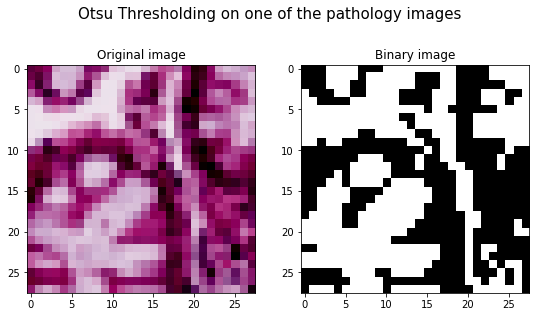

In [75]:
import cv2
from skimage.filters import threshold_otsu

# get the first image in the test set
image = test_images[11].unsqueeze(0)

# convert the image to a numpy array
image = np.transpose(image.cpu().numpy()[0], (1, 2, 0))

# Use Otsu Thresholding 
# convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# apply Otsu's thresholding method to binarize the image
thresh = threshold_otsu(gray)
binary = gray > thresh

# --------------------------
# PLOTTING
# --------------------------
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(image)
ax[0].set_title("Original image")
ax[1].imshow(binary, cmap="gray")
ax[1].set_title("Binary image")

fig.suptitle('Otsu Thresholding on one of the pathology images', fontsize=15)

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


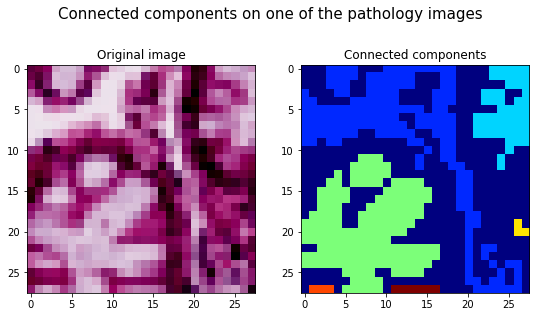

In [76]:
# now using the thresholded image, we can use the connected components algorithm to segment the image into its different components:

# find the connected components in the image
n_components, labels = cv2.connectedComponents(binary.astype(np.uint8))

# plot the image and the binary image in a side by side manner as a subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(image)
ax[0].set_title("Original image")
ax[1].imshow(labels, cmap="jet")
ax[1].set_title("Connected components")
fig.suptitle('Connected components on one of the pathology images', fontsize=15)
plt.show()


### Method 2: LIME explainability 

 - Another explainability method is LIME (Local Interpretable Model-Agnostic Explanations). We can feed in the connected components we calculated above to feed into the algorithm, this can show us which parts of the image are important for the prediction.

 <small>The LIME attribution method is one of many explainability methods, it is a model agnostic method that can be used to explain the predictions of any machine learning model. It works by perturbing the input image and observing the effect on the output of the model. The perturbed images are generated by randomly turning pixels on and off. The output of the model is then used to train a linear model that predicts the output of the model based on the perturbed images. The linear model can then be used to explain the predictions of the model. The LIME algorithm is described in more detail in the following paper: Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Why should i trust you?: Explaining the predictions of any classifier." Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 2016.</small>

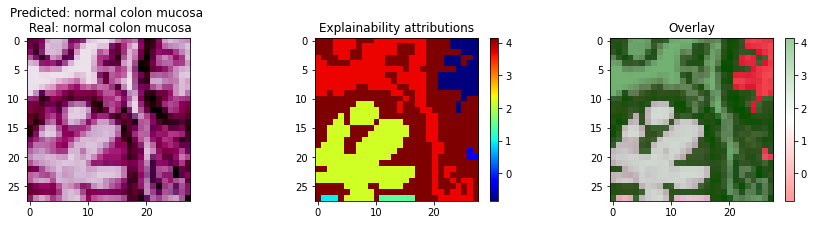

In [77]:
# use the components from openCV to define a mask to input to LIME in Captum:
from captum.attr import Lime


# to ensure reproduction of the results in LIME, we need to set the seed:
torch.manual_seed(SEED)
np.random.seed(SEED)

# set model to eval mode
model.eval()

# define the lime interpreter
lime = Lime(model)

# now use the lime interpreter to infer the importance of each pixel in the image for the model’s prediction:
# get the first image in the test set
image = test_images[11].unsqueeze(0)

# move the image to GPU if CUDA is available
image = image.to(device)

# get the model’s prediction
# set model to eval mode
model.eval()
pred = model(image)

# get the model’s prediction class
pred_class = pred.argmax(dim=1)

# define the real labels of the pathology images
real_labels = {
            0: "adipose",
            1: "background",
            2: "debris",
            3: "lymphocytes",
            4: "mucus",
            5: "smooth muscle",
            6: "normal colon mucosa",
            7: "cancer-associated stroma",
            8: "crc adenocarcinoma epithelium"
        }


# --------------------------
# PLOTTING
# --------------------------
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
# plot the image and the attributions in a side by side manner as a subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1))
ax[0].set_title(f"Predicted: {real_labels[int(pred_class.cpu().numpy())]} \n Real: {real_labels[int(test_labels[11].cpu().numpy())]}")

labels_torch = torch.from_numpy(labels).unsqueeze(0).unsqueeze(0).float().to(device)
# turn labels_torch to long
labels_torch = labels_torch.long()

# now run the lime interpreter on the image
attributions_lime = lime.attribute(image,
                                    target=pred_class,
                                    feature_mask=labels_torch,
                                    )
ax[1].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap="jet")
ax[1].set_title("Explainability attributions")

# make an overlay of the image and the attributions
ax[2].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1), cmap="gray")
ax[2].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.4)
ax[2].set_title("Overlay")

# put a colorbar on the side
fig.colorbar(ax[1].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap="jet", alpha=1.0), ax=ax[1])
fig.colorbar(ax[2].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.4), ax=ax[2])

plt.show()


 - Similar to the above, let's turn this into a function that takes as input the index of the image we want to visualize, and returns the plot:

In [78]:
# turn the above lime interpreter into a function:
def plot_attribution_image_lime(image_index, save_str=None):
    import cv2
    from skimage.filters import threshold_otsu
    from captum.attr import Lime

    torch.manual_seed(SEED)
    np.random.seed(SEED)

    # get the first image in the test set
    image = test_images[image_index].unsqueeze(0)
    # get the label of the image
    label_true = test_labels[image_index]

    # convert the image to a numpy array
    image = np.transpose(image.cpu().numpy()[0], (1, 2, 0))

    # Use Otsu Thresholding 
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply Otsu's thresholding method to binarize the image
    thresh = threshold_otsu(gray)
    binary = gray > thresh

    n_components, labels = cv2.connectedComponents(binary.astype(np.uint8))

    # use the components from openCV to define a mask to input to LIME in Captum:
    
    # set the model into eval mode
    model.eval()

    # define the lime interpreter
    lime = Lime(model)

    # now use the lime interpreter to infer the importance of each pixel in the image for the model’s prediction:
    # get the first image in the test set
    image = test_images[image_index].unsqueeze(0)

    # move the image to GPU if CUDA is available
    image = image.to(device)

    # get the model’s prediction
    pred = model(image)

    # get the model’s prediction class
    pred_class = pred.argmax(dim=1)

    # define the real labels of the pathology images
    real_labels = {
                0: "adipose",
                1: "background",
                2: "debris",
                3: "lymphocytes",
                4: "mucus",
                5: "smooth muscle",
                6: "normal colon mucosa",
                7: "cancer-associated stroma",
                8: "crc adenocarcinoma epithelium"
            }

    # --------------------------
    # PLOTTING
    # --------------------------
    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    ax[0].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1))
    ax[0].set_title(f"Predicted: {real_labels[int(pred_class.cpu().numpy())]} \n True: {real_labels[int(label_true.cpu().numpy())]}")

    labels_torch = torch.from_numpy(labels).unsqueeze(0).unsqueeze(0).float().to(device)
    # turn labels_torch to long
    labels_torch = labels_torch.long()

    # now run the lime interpreter on the image
    attributions_lime = lime.attribute(image,
                                        target=pred_class,
                                        feature_mask=labels_torch,
                                        )


    ax[1].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap="jet")
    ax[1].set_title("Explainability attributions")

    # make an overlay of the image and the attributions
    ax[2].imshow(np.clip(np.transpose(image.cpu().numpy()[0], (1, 2, 0)), 0, 1), cmap="gray")
    ax[2].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.4)
    ax[2].set_title("Overlay")

    # put a colorbar on the side
    fig.colorbar(ax[2].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap=cmap, alpha=0.3), ax=ax[2])
    # also put a colorbar on the attributions
    fig.colorbar(ax[1].imshow(attributions_lime.detach().cpu().numpy()[0][0], cmap="jet"), ax=ax[1])

    if save_str is not None:
        plt.savefig(save_str, dpi=300, bbox_inches='tight')
    return plt.show()

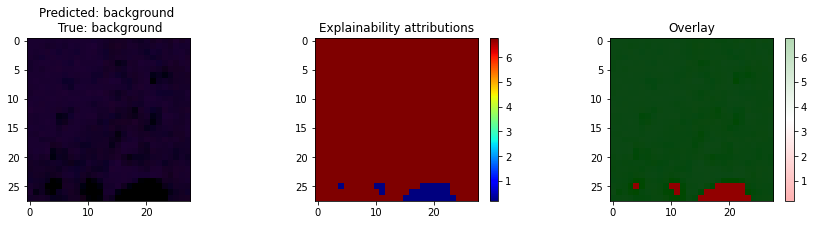

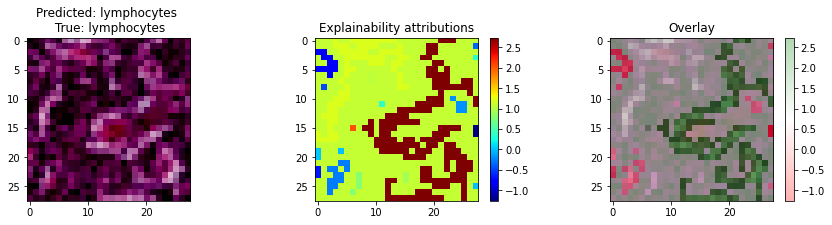

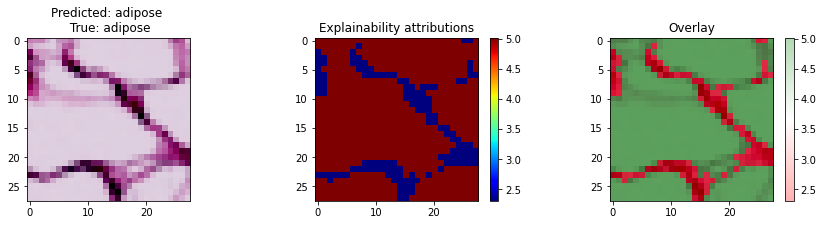

In [83]:
number_of_images = 3
for i in range(number_of_images):
    # randomly choose 3 indices from the correct indices list:
    random_indices = np.random.choice(correct_indices, number_of_images)
    plot_attribution_image_lime(random_indices[i])


### Conclusion

 - In this exercise, we have used two different explainability methods to understand the predictions of our model. In the Occlusion method, we passed in each and every pixel of the image to the model and observed the effect on the model's prediction. In the LIME method, we passed in the connected components of the image to the model and observed the effect on the model's prediction. What is important is that we too are able to interpret the explainability attributions, and understand what the model has learnt. 
 - This is a very important step in the development of a robust model, as it allows us to understand the model's strengths and weaknesses, and improve the model accordingly. It also allows us to understand the model's predictions, which is important in a clinical setting where the model is being used to aid a clinician in their diagnosis of a patient sample.